# Bayesian Multiple Regression Example

In [1]:
import bambi as bmb
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pymc3 as pm
import seaborn as sns

## Load and examine Eugene-Springfield community sample data

In [2]:
data = pd.read_csv('data/ESCS.csv')
np.round(data.describe(), 2)

,drugs,n,e,o,a,c,hones,emoti,extra,agree,consc,openn
count,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00
mean,2.21,80.04,106.52,113.87,124.63,124.23,3.89,3.18,3.21,3.13,3.57,3.41
std,0.65,23.21,19.88,21.12,16.67,18.69,0.45,0.46,0.53,0.47,0.44,0.52
min,1.00,23.00,42.00,51.00,63.00,44.00,2.56,1.47,1.62,1.59,2.00,1.28
25%,1.71,65.75,93.00,101.00,115.00,113.00,3.59,2.88,2.84,2.84,3.31,3.06
50%,2.14,76.00,107.00,112.00,126.00,125.00,3.88,3.19,3.22,3.16,3.56,3.44
75%,2.64,93.00,120.00,129.00,136.00,136.00,4.20,3.47,3.56,3.44,3.84,3.75
max,4.29,163.00,158.00,174.00,171.00,180.00,4.94,4.62,4.75,4.44,4.75,4.72


It's always a good idea to start off with some basic plotting. Here's what our outcome variable 'drugs' (some index of self-reported illegal drug use) looks like:

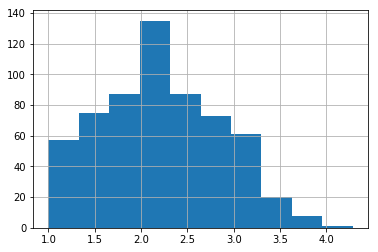

In [3]:
data['drugs'].hist();

The five predictor variables that we'll use are sum-scores measuring participants' standings on the Big Five personality dimensions. The dimensions are:
- O = Openness to experience
- C = Conscientiousness
- E = Extraversion
- A = Agreeableness
- N = Neuroticism

Here's what our predictors look like:

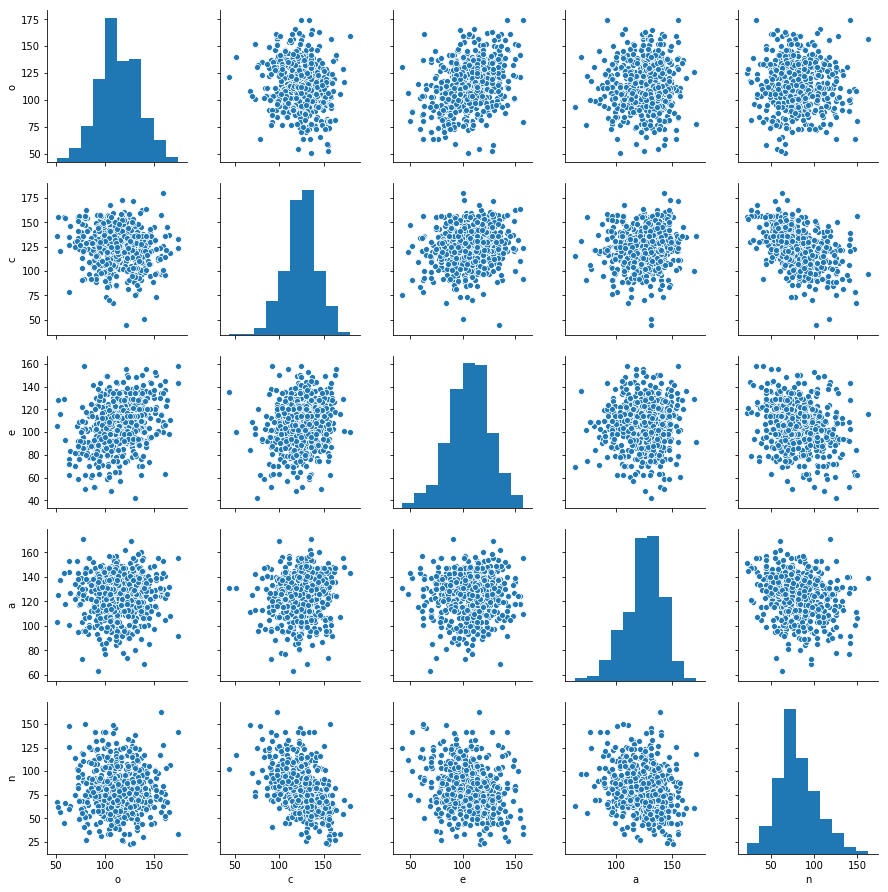

In [4]:
sns.pairplot(data[['o','c','e','a','n']]);

## Specify model and examine priors

We're going to fit a pretty straightforward multiple regression model predicting drug use from all 5 personality dimension scores. It's simple to specify the model using a familiar formula interface. Here we tell bambi to run two parallel Markov Chain Monte Carlo (MCMC) chains, each one drawing 2000 samples from the joint posterior distribution of all the parameters.

In [5]:
model = bmb.Model(data)
fitted = model.fit('drugs ~ o + c + e + a + n', samples=1000, tune=1000, init=None)

Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
NUTS: [drugs_sd, n, a, e, c, o, Intercept]
INFO:pymc3:NUTS: [drugs_sd, n, a, e, c, o, Intercept]
100%|██████████| 2000/2000 [00:24<00:00, 82.85it/s] 


Great! But this is a Bayesian model, right? What about the priors?

If no priors are given explicitly by the user, then bambi chooses smart default priors for all parameters of the model based on the implied partial correlations between the outcome and the predictors. Here's what the default priors look like in this case -- the plots below show 1000 draws from each prior distribution:

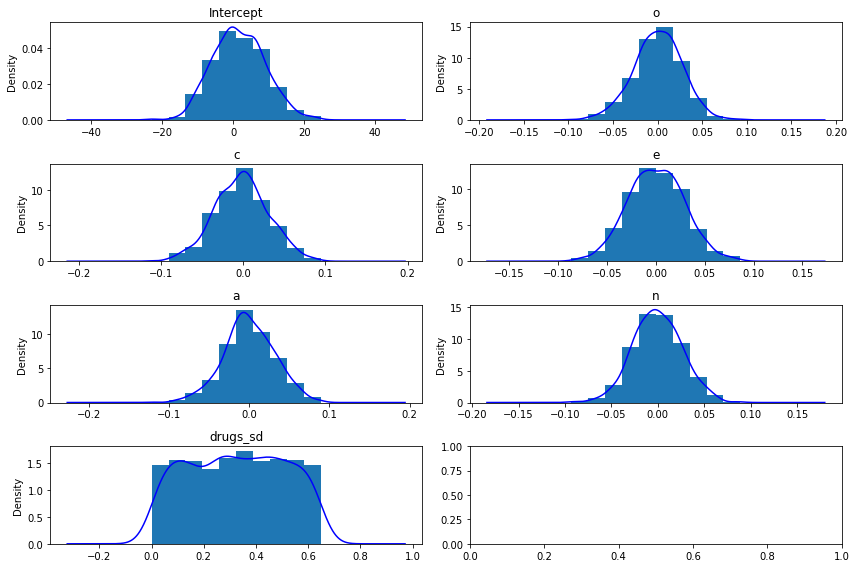

In [6]:
model.plot();

In [7]:
# Normal priors on the coefficients
{x.name:x.prior.args for x in model.terms.values()}

{'Intercept': {'mu': array([2.21014664]), 'sd': array([7.49872428])},
 'o': {'mu': array([0]), 'sd': array([0.02706881])},
 'c': {'mu': array([0]), 'sd': array([0.03237049])},
 'e': {'mu': array([0]), 'sd': array([0.02957413])},
 'a': {'mu': array([0]), 'sd': array([0.03183624])},
 'n': {'mu': array([0]), 'sd': array([0.0264199])}}

In [8]:
# Uniform prior on the residual standard deviation
model.y.prior.args['sd'].args

{'lower': array(0), 'upper': array(0.64877877)}

Some more info about the default prior distributions can be found in [this technical paper](https://arxiv.org/abs/1702.01201).

Notice the small SDs of the slope priors. This is due to the relative scales of the outcome and the predictors: remember from the plots above that the outcome, `drugs`, ranges from 1 to about 4, while the predictors all range from about 20 to 180 or so. So a one-unit change in any of the predictors -- which is a trivial increase on the scale of the predictors -- is likely to lead to a very small absolute change in the outcome. Believe it or not, these priors are actually quite wide on the partial correlation scale!

## Examine the model results

Let's start with a pretty picture of the parameter estimates!

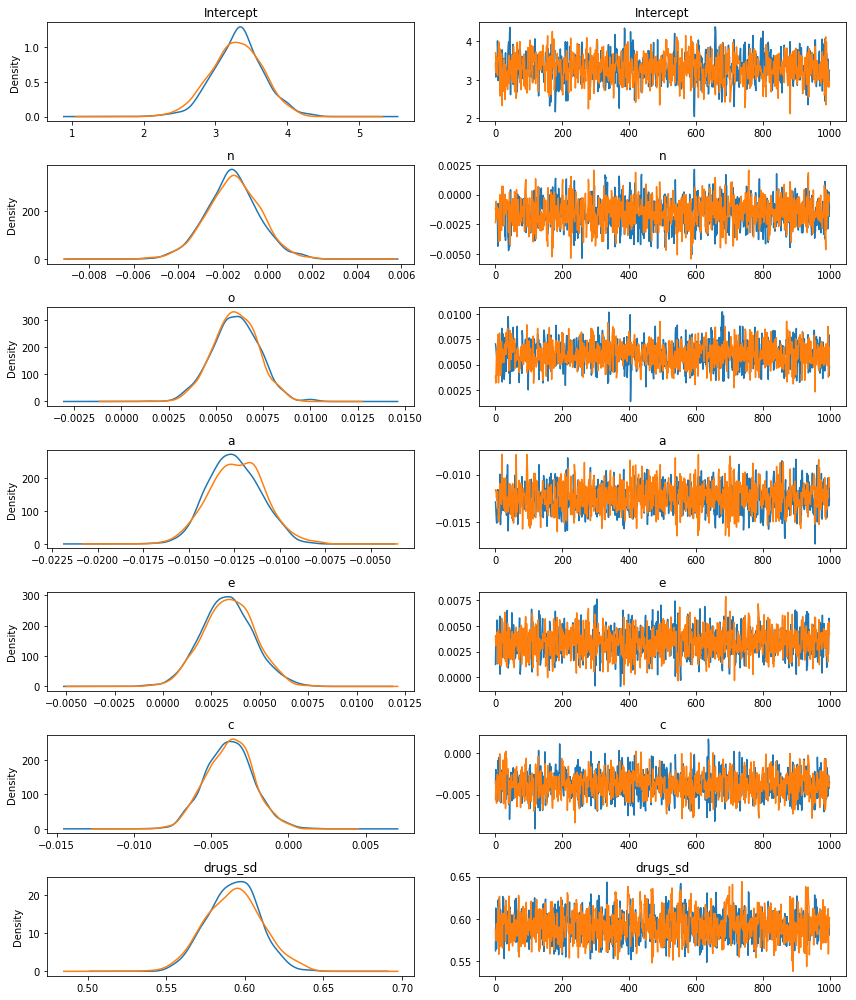

In [9]:
fitted.plot();

The left panels show the marginal posterior distributions for all of the model’s parameters, which summarize the most plausible values of the regression coefficients, given the data we have now observed. These posterior density plots show two overlaid distributions because we ran two MCMC chains. The panels on the right are "trace plots" showing the sampling paths of the two MCMC chains as they wander through the parameter space. 

A much more succinct (non-graphical) summary of the parameter estimates can be found like so:

In [10]:
fitted.summary()

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
Intercept,3.306788,0.350794,2.669343,4.043687,1125.481830,1.001945
n,-0.001545,0.001171,-0.003944,0.000732,1436.056288,1.000048
o,0.006041,0.001189,0.003704,0.008393,1524.267732,0.999558
a,-0.012419,0.001449,-0.015050,-0.009481,1408.252642,1.003233
e,0.003371,0.001320,0.000809,0.005919,1694.707896,1.000497
c,-0.003806,0.001503,-0.006978,-0.001149,1356.351417,0.999537
drugs_sd,0.592951,0.016867,0.559014,0.624859,1438.667543,0.999888


When there are multiple MCMC chains, the default summary output includes some basic convergence diagnostic info (the effective MCMC sample sizes and the Gelman-Rubin "R-hat" statistics), although in this case it's pretty clear from the trace plots above that the chains have converged just fine.

## Summarize effects on partial correlation scale

Let's grab the samples and put them in a format where we can easily work with them. We can do this really easily using the `to_df()` method of the fitted `MCMCResults` object. 

In [11]:
samples = fitted.to_df()
samples.head()

,Intercept,n,o,a,e,c,drugs_sd
0,3.440476,-0.001174,0.007033,-0.012882,0.001259,-0.003642,0.562209
1,3.073972,-0.001429,0.006784,-0.013615,0.003824,-0.001993,0.612918
2,3.455090,-0.001833,0.006368,-0.014293,0.003591,-0.003459,0.609669
3,3.555880,-0.001826,0.005902,-0.015004,0.003906,-0.003191,0.564443
4,3.425497,-0.001180,0.005629,-0.015116,0.003624,-0.002424,0.588922


It turns out that we can convert each regresson coefficient into a partial correlation by multiplying it by a constant that depends on (1) the SD of the predictor, (2) the SD of the outcome, and (3) the degree of multicollinearity with the set of other predictors. Two of these statistics are actually already computed and stores in the fitted model object, in a dictionary called `dm_statistics` (for design matrix statistics), because they are used internally. The others we will compute manually.

In [12]:
# the names of the predictors
varnames = ['o', 'c', 'e', 'a', 'n']

# compute the needed statistics
r2_x = model.dm_statistics['r2_x']
sd_x = model.dm_statistics['sd_x']
r2_y = pd.Series([sm.OLS(endog=data['drugs'],
                         exog=sm.add_constant(data[[p for p in varnames if p != x]])).fit().rsquared
                  for x in varnames], index=varnames)
sd_y = data['drugs'].std()

# compute the products to multiply each slope with to produce the partial correlations
slope_constant = sd_x[varnames] * (1 - r2_x[varnames])**.5 \
    / sd_y / (1 - r2_y)**.5
slope_constant

o    32.392557
c    27.674284
e    30.305117
a    26.113299
n    34.130431
dtype: float64

Now we just multiply each sampled regression coefficient by its corresponding `slope_constant` to transform it into a sampled partial correlation coefficient.

In [13]:
pcorr_samples = samples[varnames] * slope_constant
pcorr_samples.head()

,o,c,e,a,n
0,0.227825,-0.100794,0.038152,-0.336382,-0.040077
1,0.219757,-0.055156,0.115887,-0.355537,-0.048786
2,0.206278,-0.095714,0.108840,-0.373232,-0.062565
3,0.191178,-0.088297,0.118359,-0.391795,-0.062335
4,0.182336,-0.067090,0.109831,-0.394735,-0.040289


And voilà! We now have a joint posterior distribution for the partial correlation coefficients. Let's plot the marginal posterior distributions:

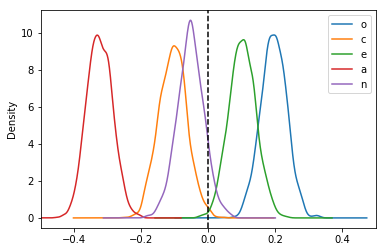

In [14]:
pcorr_samples.plot.kde(xlim=[-.5, .5]).axvline(x=0, color='k', linestyle='--')

The means of these distributions serve as good point estimates of the partial correlations:

In [15]:
pcorr_samples.mean(axis=0).sort_values()

a   -0.324302
c   -0.105328
n   -0.052734
e    0.102160
o    0.195684
dtype: float64

Naturally, these results are consistent with the OLS results. For example, we can see that these estimated partial correlations are roughly proportional to the t-statistics from the corresponding OLS regression:

In [16]:
sm.OLS(endog=data['drugs'], exog=sm.add_constant(
    data[varnames])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  drugs   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     25.54
Date:                Sat, 23 Mar 2019   Prob (F-statistic):           2.16e-23
Time:                        20:00:37   Log-Likelihood:                -536.75
No. Observations:                 604   AIC:                             1086.
Df Residuals:                     598   BIC:                             1112.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3037      0.360      9.188      0.000       2.598       4.010
o              0.0061      0.001      4.891      0.000       0.004       0.008
c             -0.0038      0.001     -2.590      0.010      -0.007      -0.001
e              0.0034      0.001      2.519      0.012       0.001       0.006
a             -0.0124      0.001     -8.391      0.000      -0.015      -0.010
n             -0.0015      0.001     -1.266      0.206      -0.004       0.001
==============================================================================
Omnibus:                       10.273   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                7.926
Skew:                           0.181   Prob(JB):                       0.0190
Kurtosis:                       2.572   Cond. No.                     3.72e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Relative importance: Which predictors have the strongest effects (defined in terms of partial $\eta^2$)?

The partial $\eta^2$ statistics for each predictor are just the squares of the partial correlation coefficients, so it's easy to get posteriors on that scale too:

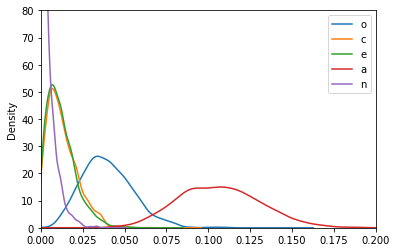

In [17]:
(pcorr_samples**2).plot.kde(xlim=[0, .2], ylim=[0, 80])

With these posteriors we can ask: What is the probability that the partial $\eta^2$ for Openness (yellow) is greater than the partial $\eta^2$ for Conscientiousness (green)?

In [18]:
(pcorr_samples['o']**2 > pcorr_samples['c']**2).mean()

0.928

For each predictor, what is the probability that it has the largest $\eta^2$?

In [19]:
(pcorr_samples**2).idxmax(axis=1).value_counts() / len(pcorr_samples.index)

a    0.992
o    0.008
dtype: float64

Agreeableness is clearly the strongest predictor of drug use among the Big Five personality traits, but it's still not a particularly strong predictor in an absolute sense. Walter Mischel famously claimed that it is rare to see correlations between personality measurse and relevant behavioral outcomes exceed 0.3. In this case, the probability that the agreeableness partial correlation exceeds 0.3 is:

In [20]:
(np.abs(pcorr_samples['a']) > .3).mean()

0.734